In [47]:
import os
import wfdb
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MultiLabelBinarizer

In [48]:
base_dir = "data"
csv_path = os.path.join(base_dir, "ptbxl_database.csv")
record_dir = os.path.join(base_dir, "records100")

In [49]:
# Load metadata
variables = pd.read_csv(csv_path, index_col=0)

# Find all .dat files from records100 with the raw ECG signals
files = glob.glob(os.path.join(record_dir, "**", "*.dat"), recursive=True)

# Extract ecg_id from filenames
labels = [os.path.splitext(os.path.basename(f))[0] for f in files]
ecg_ids = [int(label.split("_")[0]) for label in labels]

# Filter metadata to keep only rows for which we have actual ECG waveform files
variables = variables.loc[variables.index.isin(ecg_ids)]

# Reorder filtered metadata to match the order of the waveform files
ordered_indices = [id for id in ecg_ids if id in variables.index]
variables = variables.loc[ordered_indices]

In [50]:
# Shape and preview
print("Shape of variables:", variables.shape) # Rows are ECGs and columns are metadata
variables.head()

Shape of variables: (21799, 27)


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
977,6691.0,51.0,1,167.0,74.0,7.0,1.0,AT-6 C 5.8,1987-07-24 00:24:55,sinus rhythm. no definite pathology.,...,True,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00977_lr,records500/00000/00977_hr
877,11920.0,47.0,0,NaN,46.0,0.0,0.0,CS-12 E,1987-07-04 08:53:15,sinusrhythmus ueberdrehter linkstyp t abnorm i...,...,True,NaN,", alles,",NaN,NaN,NaN,NaN,7,records100/00000/00877_lr,records500/00000/00877_hr
284,3192.0,76.0,1,168.0,54.0,10.0,1.0,AT-6 C 5.5,1986-09-10 13:14:44,sinus bradycardia with sinus arrhythmia. the c...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00284_lr,records500/00000/00284_hr
33,20527.0,49.0,1,NaN,58.0,2.0,0.0,CS-12 E,1985-02-09 10:51:08,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00033_lr,records500/00000/00033_hr
762,380.0,70.0,1,151.0,51.0,10.0,1.0,AT-6 C 5.8,1987-05-08 18:06:13,sinus bradycardia. r-s transition zone in v le...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00762_lr,records500/00000/00762_hr


To ensure the dataset is ready for model training, we first handled the missing values in the metadata. Columns with more than 50% missing values (`electrodes_problems`, `infarction_stadium1`, `infarction_stadium2`, `pacemaker`, etc.) or low relevance (`nurse`, `site`, `device`, etc.) were dropped as they offered little value for the classification task and would introduce unnecessary noise.

For columns with moderate missingness but potential predictive value, such as `height` and `weight`, we imputed missing values using the median, which is a standard and robust method for handling numerical missing data.

Categorical columns, such as `sex` and `report`, had their missing values imputed using the mode, ensuring that the dataset remained complete and consistent.

In [51]:
# TODO: Give credit to https://github.com/huseyincavusbi/SE_ECGNet/blob/main/SE_ECGNet.ipynb
# Identify columns with more than 50% missing values
missing_percentages = (variables.isnull().sum() / len(variables)) * 100
high_missing_cols = missing_percentages[missing_percentages > 50].index.tolist()

# Define additional low-relevance columns to drop manually
additional_cols_to_drop = ['nurse', 'site', 'device', 'recording_date', 'validated_by']

# Combine both lists of columns to drop
cols_to_drop = high_missing_cols + additional_cols_to_drop

# Print columns to be dropped
print("Columns being dropped due to missing or low relevance:")
print("-" * 50)
for col in cols_to_drop:
    if col in variables.columns:
        print(f"{col}: {missing_percentages.get(col, 0):.2f}% missing")

# Drop the identified columns
variables_cleaned = variables.drop(columns=cols_to_drop)

# Handle remaining missing values
# Fill numeric columns with median
numeric_columns = variables_cleaned.select_dtypes(include=['float64', 'int64']).columns
variables_cleaned[numeric_columns] = variables_cleaned[numeric_columns].fillna(variables_cleaned[numeric_columns].median())

# Fill categorical columns with mode
categorical_columns = variables_cleaned.select_dtypes(include=['object']).columns
variables_cleaned[categorical_columns] = variables_cleaned[categorical_columns].fillna(variables_cleaned[categorical_columns].mode().iloc[0])

print("\nFinal cleaned metadata info:")
print(variables_cleaned.info())

Columns being dropped due to missing or low relevance:
--------------------------------------------------
height: 68.01% missing
weight: 56.78% missing
infarction_stadium1: 74.26% missing
infarction_stadium2: 99.53% missing
baseline_drift: 92.67% missing
static_noise: 85.05% missing
burst_noise: 97.19% missing
electrodes_problems: 99.86% missing
extra_beats: 91.06% missing
pacemaker: 98.67% missing
nurse: 6.76% missing
site: 0.08% missing
device: 0.00% missing
recording_date: 0.00% missing
validated_by: 43.02% missing

Final cleaned metadata info:
<class 'pandas.core.frame.DataFrame'>
Index: 21799 entries, 977 to 17052
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   report                        21799 non-

In [52]:
print("\nMissing values per column:")
print(variables_cleaned.isnull().sum())


Missing values per column:
patient_id                      0
age                             0
sex                             0
report                          0
scp_codes                       0
heart_axis                      0
second_opinion                  0
initial_autogenerated_report    0
validated_by_human              0
strat_fold                      0
filename_lr                     0
filename_hr                     0
dtype: int64


In the PTB-XL dataset, patient age is provided at the time of ECG recording. However, in compliance with HIPAA privacy standards, all patients older than 89 years are assigned a value of 300. This is a form of pseudonymization to prevent potential re-identification of elderly individuals. Since this value does not represent a real age and could skew the model or statistical summaries, we cap all age values at 89.

In [53]:
print("Sex distribution:\n", variables_cleaned["sex"].value_counts(), "\n")
print("Age summary:\n", variables_cleaned["age"].describe())

Sex distribution:
 sex
0    11354
1    10445
Name: count, dtype: int64 

Age summary:
 count    21799.000000
mean        62.769301
std         32.308813
min          2.000000
25%         50.000000
50%         62.000000
75%         72.000000
max        300.000000
Name: age, dtype: float64


In [54]:
# Cap age at 89 to avoid misleading outliers in training
variables_cleaned["age"] = variables_cleaned["age"].apply(lambda x: 89 if x == 300 else x)

In [55]:
variables_cleaned["scp_codes"]

ecg_id
977                              {'NDT': 100.0, 'SR': 0.0}
877                             {'LAFB': 100.0, 'SR': 0.0}
284      {'LVH': 100.0, 'ISC_': 100.0, 'DIG': 100.0, 'V...
33                              {'NORM': 100.0, 'SR': 0.0}
762             {'NORM': 100.0, 'NST_': 0.0, 'SBRAD': 0.0}
                               ...                        
17916    {'ASMI': 100.0, 'ALMI': 100.0, 'IMI': 100.0, '...
17603    {'LAFB': 100.0, 'LVH': 35.0, 'VCLVH': 0.0, 'SR...
17152    {'ISCAL': 100.0, 'ISCIN': 100.0, 'IRBBB': 100....
17703                           {'NORM': 100.0, 'SR': 0.0}
17052    {'ISCAL': 100.0, 'LAFB': 100.0, 'LAO/LAE': 100...
Name: scp_codes, Length: 21799, dtype: object

In [56]:
from ast import literal_eval

def safe_literal_eval(val):
    if isinstance(val, str):
        return literal_eval(val)
    return val  # Already a dict, no need to convert

variables_cleaned["scp_codes"] = variables_cleaned["scp_codes"].apply(safe_literal_eval)

Multi-label classification is required for this task because each ECG record can be associated with multiple diagnostic superclasses (`NORM`, `MI`, `STTC`, `CD`, `HYP`). To simplify the task and focus on the required classes for this assignment, we decided to focus on the three target labels: `NORM`, `MI`, and `STTC`.

To ensure the dataset only contains records relevant to these classes, we filtered out any records that did not include at least one of the three target labels (`NORM`, `MI`, `STTC`), ensuring that the model will only be trained and evaluated on these three superclasses.

In [57]:
# Load statement reference table
scp_df = pd.read_csv(os.path.join(base_dir, "scp_statements.csv"), index_col=0)

scp_df.head(10)

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
LAFB,left anterior fascicular block,1.0,NaN,NaN,CD,LAFB/LPFB,Intraventricular and intra-atrial Conduction d...,left anterior fascicular block,101.0,MDC_ECG_BEAT_BLK_ANT_L_HEMI,C62267,D3-33140
ISC_,non-specific ischemic,1.0,NaN,NaN,STTC,ISC_,Basic roots for coding ST-T changes and abnorm...,ischemic ST-T changes,226.0,NaN,NaN,NaN


In [58]:
scp_df["diagnostic_class"].dropna().unique()

array(['STTC', 'NORM', 'MI', 'HYP', 'CD'], dtype=object)

In [59]:
# Keep only rows with a diagnostic_class
scp_diagnostic_map = scp_df[scp_df["diagnostic_class"].notnull()]["diagnostic_class"].to_dict()

# Map each scp_codes dict to diagnostic superclasses
def map_to_superclasses(scp_code_dict):
    return list({scp_diagnostic_map[code] for code in scp_code_dict if code in scp_diagnostic_map})

# Add new column with mapped superclasses
variables_cleaned["diagnostic_superclass_mapped"] = variables_cleaned["scp_codes"].apply(map_to_superclasses)

variables_cleaned[["scp_codes", "diagnostic_superclass_mapped"]].head(10)

,scp_codes,diagnostic_superclass_mapped
ecg_id,,
977,"{'NDT': 100.0, 'SR': 0.0}",[STTC]
877,"{'LAFB': 100.0, 'SR': 0.0}",[CD]
284,"{'LVH': 100.0, 'ISC_': 100.0, 'DIG': 100.0, 'V...","[STTC, HYP]"
33,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
762,"{'NORM': 100.0, 'NST_': 0.0, 'SBRAD': 0.0}","[STTC, NORM]"
384,"{'NORM': 80.0, 'SR': 0.0}",[NORM]
133,"{'NDT': 100.0, 'SR': 0.0}",[STTC]
662,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
969,"{'NORM': 80.0, 'STACH': 0.0}",[NORM]


In [60]:
# Define the 3 target labels
target_labels = {"NORM", "MI", "STTC"}

# Keep records that have at least one of the target labels
variables_filtered = variables_cleaned[variables_cleaned["diagnostic_superclass_mapped"].apply(lambda x: bool(set(x) & target_labels))]

variables_filtered[["scp_codes", "diagnostic_superclass_mapped"]].head(10)

,scp_codes,diagnostic_superclass_mapped
ecg_id,,
977,"{'NDT': 100.0, 'SR': 0.0}",[STTC]
284,"{'LVH': 100.0, 'ISC_': 100.0, 'DIG': 100.0, 'V...","[STTC, HYP]"
33,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
762,"{'NORM': 100.0, 'NST_': 0.0, 'SBRAD': 0.0}","[STTC, NORM]"
384,"{'NORM': 80.0, 'SR': 0.0}",[NORM]
133,"{'NDT': 100.0, 'SR': 0.0}",[STTC]
662,"{'NORM': 100.0, 'SR': 0.0}",[NORM]
969,"{'NORM': 80.0, 'STACH': 0.0}",[NORM]
50,"{'LMI': 15.0, 'IVCD': 100.0, 'SR': 0.0}","[MI, CD]"


The multi-hot encoding approach was used to represent the target labels for each ECG. `MultiLabelBinarizer` was applied to convert the `diagnostic_superclass_mapped` column (which contains lists of superclasses) into a binary matrix, where each row represents an ECG and each column corresponds to the presence (1) or absence (0) of one of the target labels. Labels such as `CD` and `HYP` were intentionally excluded from this encoding, as they are outside the scope of the task and should not influence model predictions or evaluation.

This approach allows the model to learn which of the target classes (`NORM`, `MI`, `STTC`) are associated with each ECG, even if multiple labels are present.

To ensure proper evaluation and generalization of the classification models, we followed the official 10-fold stratified split provided by the PTB-XL dataset authors. This split keeps all records from the same patient within the same fold, avoiding data leakage.

Specifically, we used:
- Folds 1–9 for training
- Fold 10 for testing

To reduce computational complexity and memory usage, we used the downsampled version of the ECG recordings at 100 Hz, accessed via the `filename_lr` column.
The label vectors (`y_train`,`y_test`) were already multi-hot encoded using the `MultiLabelBinarizer`, allowing the model to learn from ECGs with multiple diagnostic labels (`NORM`, `MI`, `STTC`).

In [61]:
fs = 100 # Use downsampled signals

# Load ECG signal data
def load_raw_data(df, fs, base_path):
    if fs == 100:
        paths = df["filename_lr"]
    else:
        paths = df["filename_hr"]
    signals = []
    for f in paths:
        full_path = os.path.join(base_path, f)
        signal, _ = wfdb.rdsamp(full_path)
        signals.append(signal)
    return np.array(signals)

# Split data into train and test
test_fold = 10
train_df = variables_filtered[variables_filtered["strat_fold"] != test_fold]
test_df  = variables_filtered[variables_filtered["strat_fold"] == test_fold]

# Load ECG training data
X_train = load_raw_data(train_df, fs, base_dir)
X_test  = load_raw_data(test_df, fs, base_dir)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=["NORM", "MI", "STTC"])

# Fit the MultiLabelBinarizer on the entire dataset (variables_filtered)
mlb.fit(variables_filtered["diagnostic_superclass_mapped"])

# Now apply the fitted MultiLabelBinarizer to transform the labels for train and test data
y_train = mlb.transform(train_df["diagnostic_superclass_mapped"])
y_test  = mlb.transform(test_df["diagnostic_superclass_mapped"])

# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (16954, 1000, 12)
y_train shape: (16954, 3)
X_test shape: (1891, 1000, 12)
y_test shape: (1891, 3)


/Users/taniapazospuig/anaconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['CD', 'HYP'] will be ignored
  warnings.warn(


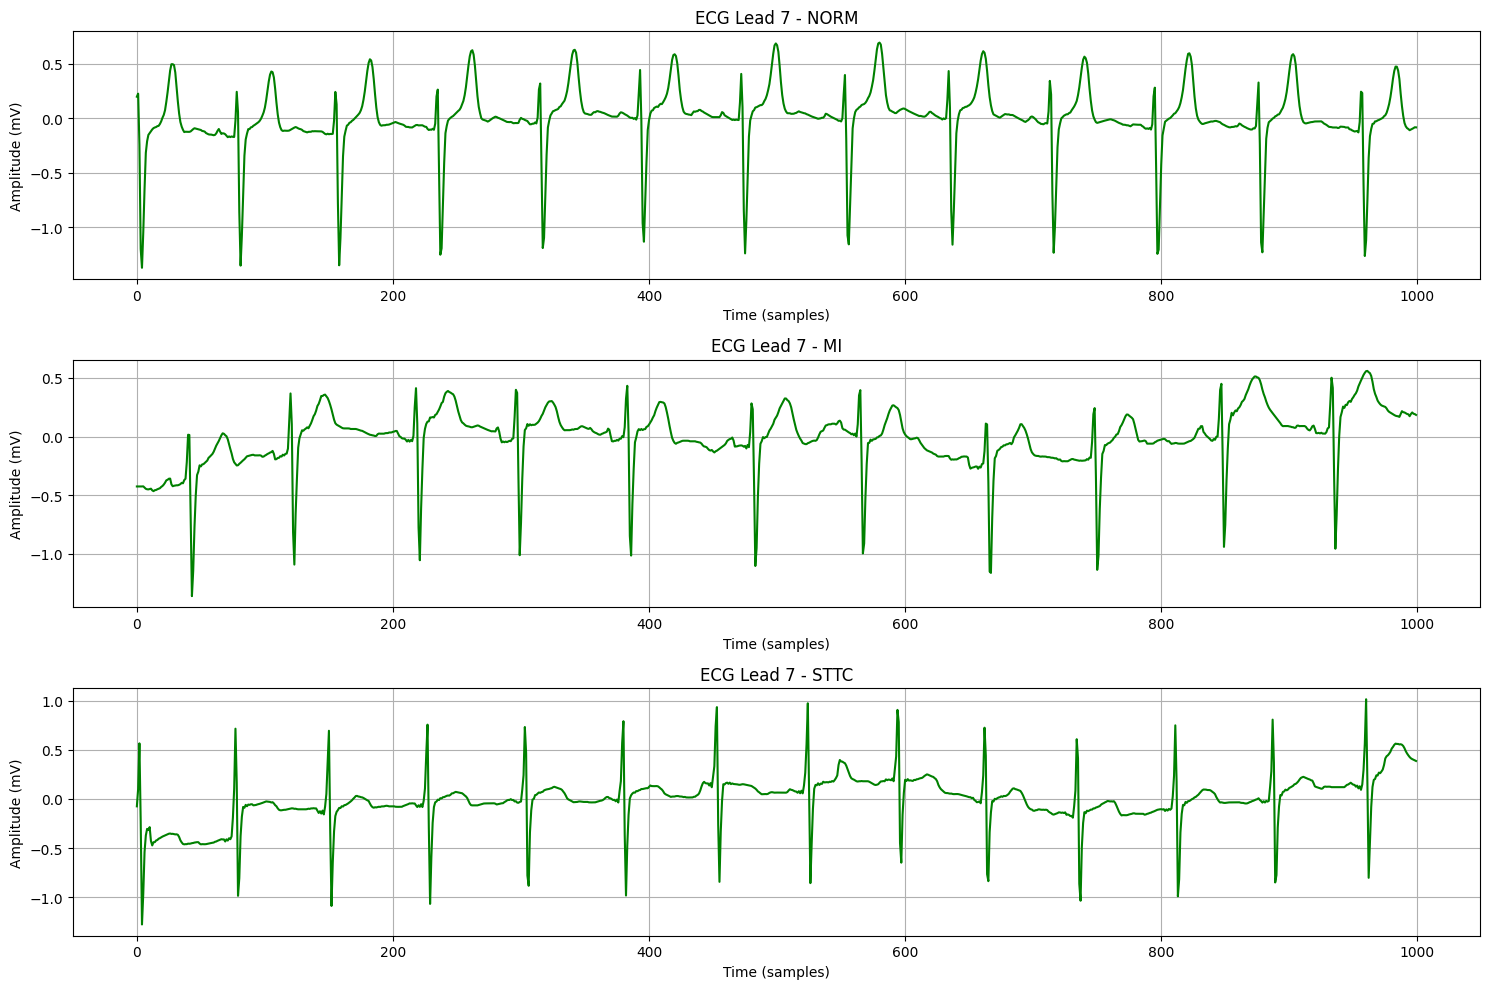

In [91]:
import matplotlib.pyplot as plt

# Function to plot a sample ECG from each class (NORM, MI, STTC)
def plot_one_sample_per_class(X, y, labels):
    plt.figure(figsize=(15, 10))
    
    for i, label in enumerate(labels):
        # Get the indices of the samples that match the label
        indices = [idx for idx, label_list in enumerate(y) if label in label_list]

        if len(indices) == 0:
            print(f"No samples found for label: {label}")
            continue  # Skip if no samples are found for this label
        
        # Select one sample for the current label
        sample_idx = indices[0]  
        ecg_signal = X[sample_idx]  # Get the ECG signal
        lead = 7 # Lead 8
        
        # Plot the signal for the current label
        plt.subplot(len(labels), 1, i + 1)
        plt.plot(ecg_signal[:, lead], color='green')
        plt.title(f"ECG Lead {lead} - {label}")
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude (mV)')
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

labels = ["NORM", "MI", "STTC"]
label_column = train_df["diagnostic_superclass_mapped"]

plot_one_sample_per_class(X_train, label_column, labels)

We evaluated the quality of ECG signals using the Signal-to-Noise Ratio (SNR) across all 12 leads in the training set.
Since raw ECGs do not have clean ground truth references, we computed:
- Pre-filter SNR by estimating signal power vs. variance (as a proxy for noise)
- Post-filter SNR by treating the filtered signal as the clean reference and computing noise as the difference between the raw and filtered signals.

In [63]:
batch_size = 100
num_leads = X_train.shape[2]

# Compute SNR of raw signals (before filtering)
# Before filtering, we do not have a clean signal to compare to
# We use the raw signal to compute its power, and its variance to estimate noise
def compute_raw_snr_batch(X):
    signal_power_total = np.zeros(num_leads)
    noise_power_total = np.zeros(num_leads)

    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]

        for signal_raw in batch:
            # Compute average signal power per lead
            signal_power = np.mean(np.square(signal_raw), axis=0)

            # Estimate noise power per lead as the variance
            noise_power = np.var(signal_raw, axis=0)

            signal_power_total += signal_power
            noise_power_total += noise_power

    # Average over all ECGs
    P_signal_avg = signal_power_total / len(X)
    P_noise_avg = noise_power_total / len(X)

    # Compute SNR and convert to decibels
    snr = P_signal_avg / P_noise_avg
    snr_db = 10 * np.log10(snr)

    return snr, snr_db

To improve the signal quality, we applied a standard preprocessing pipeline consisting of:
1. High-pass filter (0.5 Hz): This removes baseline drift and low-frequency noise that may affect the ECG signal’s morphology.
2. Low-pass filter (45 Hz): This eliminates high-frequency noise, such as electrical interference, while preserving the key frequencies for ECG analysis.
3. Detrending: This step removes any linear trends in the signal that could distort the analysis.

We used mirrored padding to mitigate edge artifacts that occur when filtering signals near the start and end. This ensures that the filtered signal respects the original morphology and avoids introducing unwanted distortions, especially at the edges.

In [64]:
from scipy import signal

# Filtering function
def apply_filters_with_padding(ecg, fs, pad_len=200):
    """
    Apply high-pass and low-pass filters with mirrored padding to avoid edge distortion.

    Parameters:
        ecg (ndarray): ECG signal of shape (n_samples, n_leads)
        fs (int): Sampling frequency (e.g., 100 Hz)
        pad_len (int): Number of samples to pad on each side

    Returns:
        ndarray: Filtered ECG signal of same shape
    """
    # Mirror padding along the time axis
    ecg_padded = np.pad(ecg, ((pad_len, pad_len), (0, 0)), mode='reflect')

    # High-pass filter (0.5 Hz)
    ecg_padded = signal.filtfilt(*signal.butter(2, 0.5, 'high', fs=fs), ecg_padded, axis=0)

    # Low-pass filter (45 Hz)
    ecg_padded = signal.filtfilt(*signal.butter(2, 45.0, 'low', fs=fs), ecg_padded, axis=0)

    # Remove linear trend
    ecg_padded = signal.detrend(ecg_padded, axis=0)

    # Remove padding
    ecg_filtered = ecg_padded[pad_len:-pad_len, :]

    return ecg_filtered

# Compute SNR in batches to avoid memory issues
def compute_power_snr_batch(X, fs):
    signal_power_total = np.zeros(num_leads)
    noise_power_total = np.zeros(num_leads)
    
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]
        
        # Split the data into batches
        for signal_raw in batch:
            signal_filtered = apply_filters_with_padding(signal_raw, fs)
            noise = signal_raw - signal_filtered

            # Compute average power per lead for clean and noisy signals
            signal_power = np.mean(np.square(signal_filtered), axis=0)
            noise_power = np.mean(np.square(noise), axis=0)

            signal_power_total += signal_power
            noise_power_total += noise_power

    # Average over all processed signals
    P_signal_avg = signal_power_total / len(X)
    P_noise_avg = noise_power_total / len(X)
    snr = P_signal_avg / P_noise_avg
    snr_db = 10 * np.log10(snr)

    return snr, snr_db

In [65]:
# Compute SNR before filtering
snr_raw, snr_raw_db = compute_raw_snr_batch(X_train)

# Compute SNR after filtering
snr_filtered, snr_filtered_db = compute_power_snr_batch(X_train, fs=100)

# Display the results per lead
print(f"{'Lead':<6}{'Raw SNR (dB)':<15}{'Filtered SNR (dB)':<20}{'Delta SNR (dB)':<10}")
print("-" * 50)
for i in range(num_leads):
    delta = snr_filtered_db[i] - snr_raw_db[i]
    print(f"{i+1:<6}{snr_raw_db[i]:<15.2f}{snr_filtered_db[i]:<20.2f}{delta:<10.2f}")

Lead  Raw SNR (dB)   Filtered SNR (dB)   Delta SNR (dB)
--------------------------------------------------
1     0.41           6.18                5.77      
2     0.08           6.43                6.35      
3     0.43           3.74                3.31      
4     0.18           7.31                7.13      
5     0.55           4.42                3.87      
6     0.19           4.68                4.49      
7     0.02           5.04                5.01      
8     0.01           8.48                8.48      
9     0.00           7.09                7.08      
10    0.31           6.04                5.73      
11    0.14           5.55                5.41      
12    1.49           -0.65               -2.14     


The SNR of the ECG signals was evaluated before and after filtering to assess the quality of the data.
* Raw SNR: Most leads exhibited low raw SNR values, indicating significant noise present in the raw ECG signals. However, lead 12 had a relatively high raw SNR (1.49 dB), suggesting better signal quality compared to other leads.
* Filtered SNR: After applying the filtering pipeline, which included a high-pass and low-pass filter along with detrending, the SNR improved across most leads. Many leads showed a notable increase in SNR, indicating that the filtering effectively removed unwanted noise in the high- and low-frequency ranges.
* Delta SNR: The change in SNR generally shows improvements, with some leads exhibiting significant increases in SNR. However, lead 12 experienced a substantial drop in SNR, suggesting that the filtering process may have distorted this signal, leading to more noise than expected.

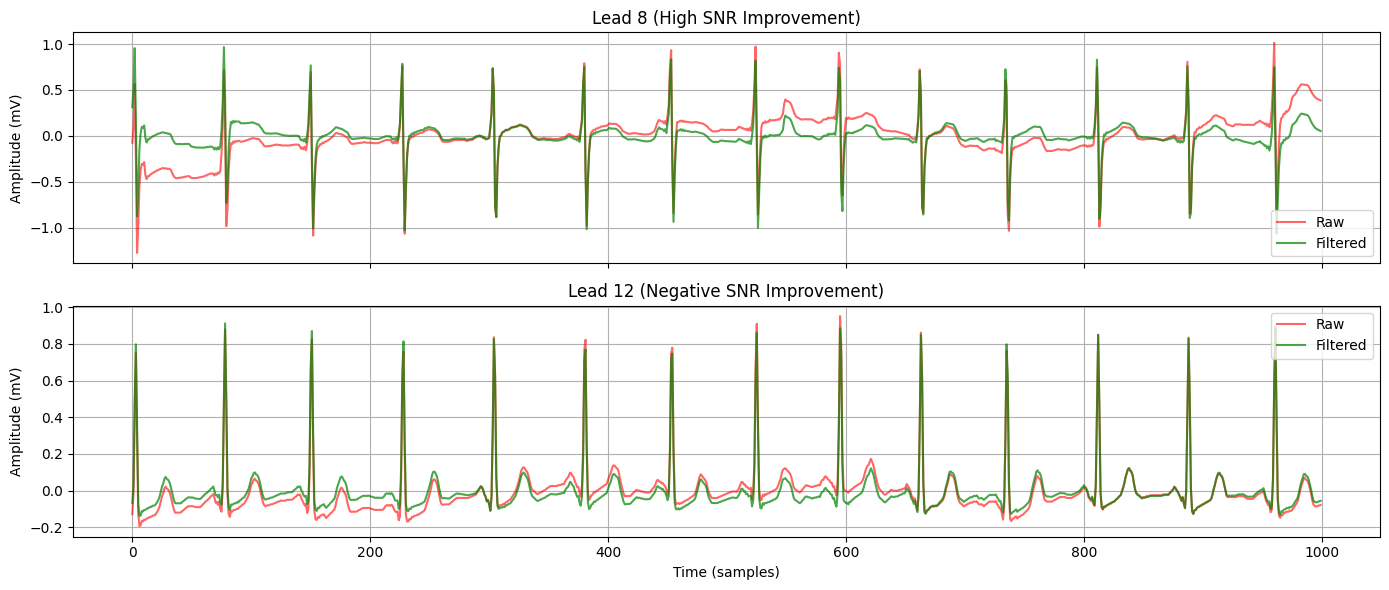

In [66]:
import matplotlib.pyplot as plt

# Sample index to visualize
sample_idx = 0

# Get raw and filtered signals
raw_signal = X_train[sample_idx]
filtered_signal = apply_filters_with_padding(raw_signal, fs=100)

# Leads to inspect
lead_good = 7   # Lead 8
lead_bad = 11  # Lead 12

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Lead with high SNR improvement
axes[0].plot(raw_signal[:, lead_good], label="Raw", color='red', alpha=0.6)
axes[0].plot(filtered_signal[:, lead_good], label="Filtered", color='green', alpha=0.7)
axes[0].set_title("Lead 8 (High SNR Improvement)")
axes[0].set_ylabel("Amplitude (mV)")
axes[0].legend()
axes[0].grid()

# Lead with poor SNR improvement
axes[1].plot(raw_signal[:, lead_bad], label="Raw", color='red', alpha=0.6)
axes[1].plot(filtered_signal[:, lead_bad], label="Filtered", color='green', alpha=0.7)
axes[1].set_title("Lead 12 (Negative SNR Improvement)")
axes[1].set_xlabel("Time (samples)")
axes[1].set_ylabel("Amplitude (mV)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [67]:
# Store filtered signals for later steps
X_train_filtered = np.array([apply_filters_with_padding(x, fs=100) for x in X_train])
X_test_filtered  = np.array([apply_filters_with_padding(x, fs=100) for x in X_test])